Try to generate room imprints with pre-defined templates and seeds

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

import random
from grid import *
from utils import *
from floor import *
import cv2 as cv
import os

In [17]:
print(os.getcwd())

c:\Users\mehds\Documents\EPFL\MA4\Procedural_Building_Generation\ProceduralBuildingGeneration


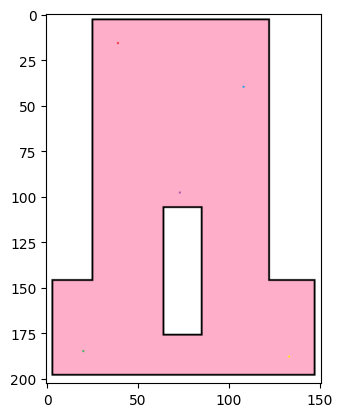

In [18]:
floorplans = []
data_dir = "data/pre_defined/"
for filename in os.listdir(data_dir):
    if filename.lower().endswith(('.png', 'jpeg')):
        filepath = os.path.join(data_dir, filename)
        floorplan = cv.imread(filepath)
        floorplan = cv.cvtColor(floorplan, cv.COLOR_BGR2RGB)
        plt.imshow(floorplan)
        floorplans.append(floorplan)

(684, 760, 3)


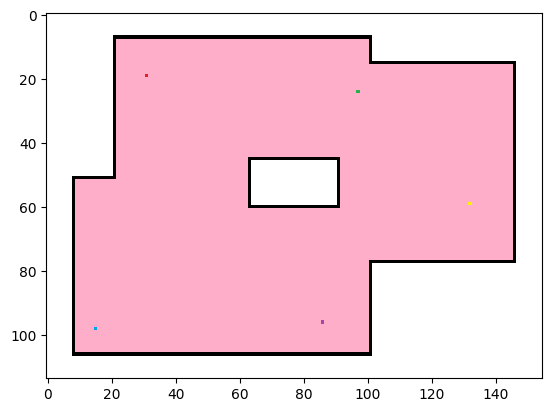

In [19]:
plt.imshow(floorplans[1])
print(floorplans[0].shape)

In [20]:
def image_to_int(floorplan):
    """
    Processes a floorplan image and converts it into a NumPy array with specific values.
    Also extracts the coordinates of seed pixels.
    Args:
        floorplan: Floorplan to be processed

    Returns:
        np.array: Processed NumPy array.
        list: List of seed coordinates in the format [(x1, y1, value1), (x2, y2, value2), ...].
    """
    color_to_value = {
        (0, 0, 0): 1,          # Walls (black)
        (255, 255, 255): 0,    # Outside (white)
        (255, 174, 201): 255,  # Inside (pink)
        (237, 28, 36): 128,      # Seed 1 (red)
        (0, 162, 232): 129,      # Seed 2 (blue)
        (34, 177, 76): 130,      # Seed 3 (green)
        (163, 73, 164): 132,    # Seed 4 (purple)
        (255, 127, 39): 136,    # Seed 5 (orange)
        (255, 242, 0): 144     # Seed 6 (yellow)
    }
    y_max, x_max, _ = floorplan.shape
    floorplan_int = np.zeros((y_max, x_max), dtype=np.uint8)
    seeds = []

    for y in range(y_max):
        for x in range(x_max):
            pixel = tuple(floorplan[y, x])
            if pixel in color_to_value:
                floorplan_int[y, x] = color_to_value[pixel]
                if floorplan_int[y, x] in [128, 129, 130, 132, 136, 144]:
                    seeds.append((x, y, floorplan_int[y, x]))
            else:
                raise ValueError(f"Unexpected color {pixel} at position ({x}, {y})")

    return floorplan_int, seeds

def plot_floorplan(output_array, seed_coordinates=None, save=False):
    """
    Plots the processed floorplan and highlights seed coordinates.

    Args:
        output_array (np.array): Processed floorplan array.
        seed_coordinates (list): List of seed coordinates in the format [(x1, y1, value1), ...].
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(output_array, cmap="viridis", vmin=0, vmax=255)
    plt.colorbar(label="Pixel Value")
    plt.title("Processed Floorplan")
    if (seed_coordinates):
        for seed in seed_coordinates:
            print(seed)
            x, y, value = seed
            plt.scatter(x, y, color="red", s=50, edgecolors="white", label=f"Seed {value}")
            plt.text(x, y, f"{value}", color="white", fontsize=12, ha="center", va="center")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    if (save):
        filename = f"Floor_{seed_coordinates[0][0]}.png"  # Use the first seed's x-coordinate in the filename
        plt.savefig(filename, dpi=300, bbox_inches="tight")  # Save with high resolution and tight bounding box
    plt.show()
    plt.close()  # Close the figure to free up memory



In [21]:
def plot_floorplan(output_array, seed_coordinates=None, save=False):
    """
    Plots the processed floorplan and highlights seed coordinates.

    Args:
        output_array (np.array): Processed floorplan array.
        seed_coordinates (list): List of seed coordinates in the format [(x1, y1, value1), ...].
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(output_array, cmap="viridis", vmin=0, vmax=255)
    plt.colorbar(label="Pixel Value")
    plt.title("Processed Floorplan")
    if (seed_coordinates):
        for seed in seed_coordinates:
            print(seed)
            x, y, value = seed
            plt.scatter(x, y, color="red", s=50, edgecolors="white", label=f"Seed {value}")
            plt.text(x, y, f"{value}", color="white", fontsize=12, ha="center", va="center")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    if (save):
        filename = f"Floor_{seed_coordinates[0][0]}.png"  # Use the first seed's x-coordinate in the filename
        plt.savefig(filename, dpi=300, bbox_inches="tight")  # Save with high resolution and tight bounding box
    plt.show()
    plt.close()  # Close the figure to free up memory



In [ ]:
floorplans_int, seeds = [], []
for floorplan in floorplans[1:]:
    floorplan_int, seed = image_to_int(floorplan)
    #plot_floorplan(floorplan_int, seed)
    floorplans_int.append(floorplan_int)
    seeds.extend([seed])

: 

In [ ]:
print(seeds[0][0])

(31, 19, 128)


(21, 16, 130)
(107, 16, 129)
(55, 44, 144)
(116, 57, 132)
(20, 86, 128)


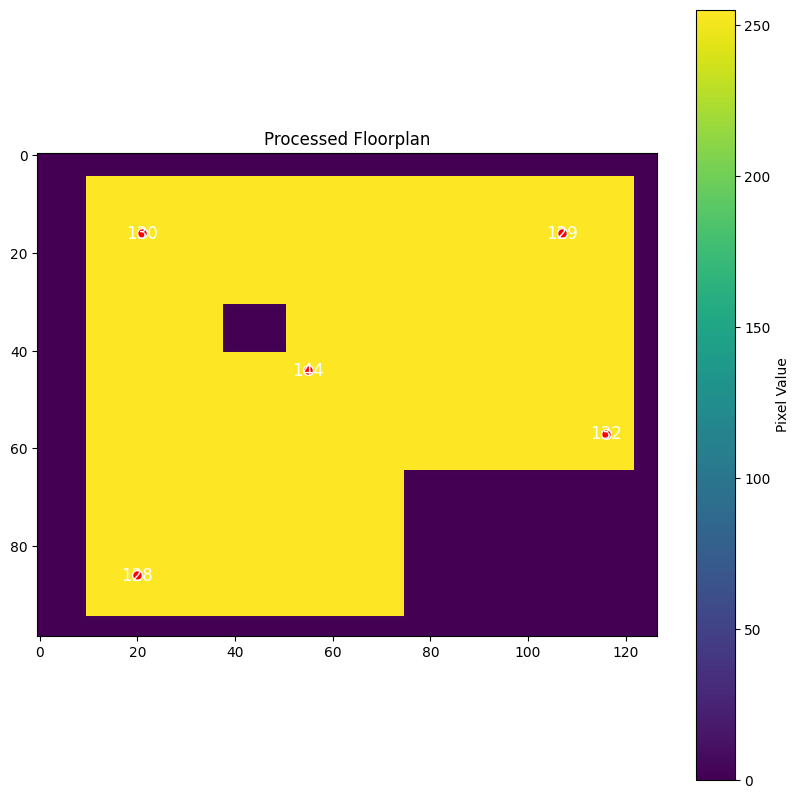

(99, 127)


In [ ]:
plot_floorplan(floorplans_int[1], seeds[1])
print(floorplans_int[1].shape)

In [ ]:
from collections import deque

def region_growing_simultaneous(grid, seeds):
    """
    Grows seeds simultaneously by 1 pixel per round.
    Args:
        grid (np.array): Input floorplan grid.
        seeds (list): List of seed coordinates [(x1, y1, value1), ...].
        connectivity (int): 4 or 8 for 4-connected or 8-connected growth.
    Returns:
        np.array: Grid with grown regions.
    """
    # Create a copy of the grid to store the result
    result = grid.copy()
    directions = [(-1, -1), (-1, 0), (-1, 1),
                  (0, -1)          , (0, 1), 
                  (1, -1) ,  (1, 0), (1, 1)]  # 8-connected
    directions = [          (-1, 0),
                  (0, -1)          , (0, 1), 
                            (1, 0)]  # 4-connected

    # Initialize a queue with all seeds
    queue = deque()
    for x, y, value in seeds:
        queue.append((y, x, value))  # Store (x, y, value) for each seed
        result[y, x] = value  # Mark the seed position in the result grid

    # Perform simultaneous region growing
    while queue:
        round_size = len(queue)# Process all pixels in the current round
        for _ in range(round_size):
            x, y, value = queue.popleft()
            for dx, dy in directions:
                nx, ny = x + dx, y + dy
                # Check if the neighbor is inside (255) and not already assigned
                if 0 <= nx < grid.shape[0] and 0 <= ny < grid.shape[1] and result[nx, ny] == 255:
                    has_adjacent_region = False # Check if the neighbor has any adjacent pixels from other regions
                    for ddy, ddx in directions: 
                        nny, nnx = ny + ddy, nx + ddx
                        if 0 <= nnx < grid.shape[0] and 0 <= nny < grid.shape[1]:
                            adj_val = result[nnx][nny]
                            if adj_val != 255 and adj_val != value:
                                has_adjacent_region = True
                                break
                    # If no adjacent regions, assign the value
                    if not has_adjacent_region:
                        result[nx, ny] = value  # Assign the seed's value
                        queue.append((nx, ny, value))  # Add to the queue for the next round
    return result

def fit_largest_rectangle(grid, room_number):
    """ 
    Fit largest rectangle in room with room cells.
    Returns the coordinates of the largest rectangle as (top, left, bottom, right).
    If no room is found, returns None.

    Algorithm is Leetcode's 85th one
    Solution and explanation here:https://algo.monster/liteproblems/85
    """
    if grid.size == 0:
        return None
    
    max_area = 0
    max_coords = (0, 0, 0, 0)
    rows, cols = grid.shape
    heights = [0] * cols  # Initialize heights array for histogram
    
    for row_idx in range(rows):
        for col in range(cols):
            if grid[row_idx][col] == room_number:
                heights[col] += 1
            else:
                heights[col] = 0
        
        # Find the largest rectangle in the current histogram using a stack
        stack = [-1]  # Initialize stack with -1 to help with boundary calculations
        for i in range(cols + 1):
            # Current height is heights[i] if within bounds, else 0 to trigger a flush
            current_height = heights[i] if i < cols else 0
            
            # Pop from stack while the current height is less than the stack's top
            while stack[-1] != -1 and current_height < heights[stack[-1]]:
                h = heights[stack.pop()]
                # Width is from the previous stack element to current index minus one
                w = i - stack[-1] - 1
                area = h * w
                # Update max_area and coordinates if this is the largest found so far
                if area > max_area:
                    max_area = area
                    left = stack[-1] + 1
                    right = i - 1
                    top = row_idx - h + 1
                    bottom = row_idx
                    max_coords = (top, left, bottom, right)
            
            stack.append(i)
    
    return max_coords if max_area > 0 else None

def build_wall(grid, a, b):
    """
    Builds a straight wall between points a and b on the grid.
    Walls can be either horizontal or vertical.
    """
    x_a, y_a = a
    x_b, y_b = b

    if not(x_a == x_b or y_a == y_b):
        raise ValueError(f"Wall is not straight")
        
    if y_a == y_b:
        for x in range(min(x_a, x_b), max(x_a, x_b) + 1):
            if (grid[x][y_a] == 1) or (grid[x][y_a] == 0):
                continue
            grid[x][y_a] = 18  # Mark as wall

    else: # Build vertical wall
        for y in range(min(y_a, y_b), max(y_a, y_b) + 1):
            if (grid[x_a][y] == 1) or (grid[x_a][y] == 0):
                continue
            grid[x_a][y] = 18  # Mark as wall

    return grid

def generate_mapping_rectangles(grid, rooms=(128, 129, 130, 132, 136, 144)):
    """
    Fills the largest rectangle in each room with the given value.
    """
    # Step 1: Find Corners

    corners_rooms = []
    corners_T = []
    corners_floor = mark_corners_floor(grid)

    for room in rooms:
        rect = fit_largest_rectangle(grid, room)
        if rect is None:
            continue  # Skip if no rectangle is found

        top, left, bottom, right = rect

        tl = (top, left)#-1, left-1) # Top-left corner
        corners_rooms.append(tl)
        corners_T.extend(mark_corners_T(grid, *tl, 'top_left'))

        bl = (bottom, left)#+1, left-1) # Bottom-left corner
        corners_rooms.append(bl)
        corners_T.extend(mark_corners_T(grid, *bl, 'bottom_left'))

        tr = (top, right)#-1, right+1) # Top-right corner
        corners_rooms.append(tr)
        corners_T.extend(mark_corners_T(grid, *tr, 'top_right'))

        br = (bottom, right)#+1, right+1) # Bottom-right corner
        corners_rooms.append(br)
        corners_T.extend(mark_corners_T(grid, *br, 'bottom_right'))
        
    corners_all = list(set(corners_floor + corners_rooms + corners_T)) # Combine corners and remove duplicates

    # Step 2 Generate rectangles
    corners_all = gen_rect_corners(corners_all)
    
    for rect in corners_all:
        (x1, y1), (x2, y2) = rect
        #grid = fill_rectangle_dominant(grid, rect)
        
        grid = build_wall(grid, (x1, y1), (x2, y1))  # Top wall
        grid = build_wall(grid, (x1, y2), (x2, y2))  # Bottom wall
        grid = build_wall(grid, (x1, y1), (x1, y2))  # Left wall
        grid = build_wall(grid, (x2, y1), (x2, y2))  # Right wall

    result_grid = fill_rooms_with_dominant_color(grid)
    result_grid = replace_walls(result_grid)
    result_grid = replace_walls(result_grid)
    return result_grid

def find_rooms(grid):
    """Identify rooms using flood fill, separated by walls (18)."""
    rows, cols = grid.shape
    visited = np.zeros_like(grid, dtype=bool)
    rooms = []

    def bfs(start_x, start_y):
        """Find room bounds and collect pixels."""
        queue = deque([(start_x, start_y)])
        visited[start_x][start_y] = True
        pixels = []
        min_x = max_x = start_x
        min_y = max_y = start_y

        while queue:
            x, y = queue.popleft()
            pixels.append(grid[x][y])
            min_x, max_x = min(min_x, x), max(max_x, x)
            min_y, max_y = min(min_y, y), max(max_y, y)

            for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < rows and 0 <= ny < cols:
                    if not visited[nx][ny] and grid[nx][ny] != 18 and grid[nx][ny] != 1 and grid[nx][ny] != 0:
                        visited[nx][ny] = True
                        queue.append((nx, ny))

        return ((min_x, min_y), (max_x, max_y)), pixels

    for i in range(rows):
        for j in range(cols):
            if not visited[i][j] and (grid[i][j] != 18 or grid[i][j] != 1):
                bounds, pixels = bfs(i, j)
                rooms.append((bounds, pixels))
    
    return rooms

def fill_rooms_with_dominant_color(grid):
    """Fill each room with its dominant color (excluding walls)."""
    rooms = find_rooms(grid)
    new_grid = np.copy(grid)
    
    for (min_x, min_y), (max_x, max_y) in [room[0] for room in rooms]:
        for x in range(min_x, max_x + 1): # Preserve walls around the room
            if grid[x][min_y] == 18 or grid[x][min_y] == 1 or grid[x][min_y] == 0:
                new_grid[x][min_y] = grid[x][min_y]
            if grid[x][max_y] == 18 or grid[x][max_y] == 1 or grid[x][max_y] == 0:
                new_grid[x][max_y] = grid[x][max_y]
        for y in range(min_y, max_y + 1):
            if grid[min_x][y] == 18 or grid[min_x][y] == 1 or grid[min_x][y] == 0:
                new_grid[min_x][y] = grid[min_x][y]
            if grid[max_x][y] == 18 or grid[max_x][y] == 1 or grid[max_x][y] == 0:
                new_grid[max_x][y] = grid[max_x][y]
    for bounds, pixels in rooms:
        (min_x, min_y), (max_x, max_y) = bounds
        freq = defaultdict(int) # Calculate dominant color (excluding walls)
        for val in pixels:
            if val != 18 or val != 1 or val != 255:
                freq[val] += 1
        if not freq:
            continue
        sorted_freq = sorted(freq.items(), key=lambda x: x[1], reverse=True)

        if sorted_freq:
            dominant = sorted_freq[0][0]
            if dominant == 255 and len(sorted_freq) > 1:
                dominant = sorted_freq[1][0]
        
        for x in range(min_x, max_x + 1): # Fill the room area
            for y in range(min_y, max_y + 1):
                if new_grid[x][y] != 18 and new_grid[x][y] != 1 and new_grid[x][y] != 0:  # Avoid overwriting walls
                    new_grid[x][y] = dominant
    
    return new_grid

from collections import defaultdict


def replace_walls(grid):
    """
    Replaces wall pixels (18) between identical regions with region's value.
    """
    SOFT_WALL = 18
    ROOM_WALL = 19
    NOT_ACCESS = {0, 1, 18, 19} # Outside, hard wall and soft wall
    rows, cols = grid.shape
    new_grid = np.copy(grid)
    
    for x in range(rows):
        for y in range(cols):
            # Check horizontal neighbors
            left = new_grid[x, y-1] if y > 0 else None
            right = new_grid[x, y+1] if y < cols-1 else None
            rightright = new_grid[x, y+2] if y < cols-2 else None
            rightrightright = new_grid[x, y+3] if y < cols-3 else None
                
            # Check vertical neighbors
            up = new_grid[x-1, y] if x > 0 else None
            down = new_grid[x+1, y] if x < rows-1 else None
            downdown = new_grid[x+2, y] if x < rows-2 else None
            downdowndown = new_grid[x+3, y] if x < rows-3 else None
            if new_grid[x, y] == SOFT_WALL:
                
                # Horizontal checks
                if left == right and left not in NOT_ACCESS:# Replace if horizontal match
                    new_grid[x, y] = left
                elif left == rightright and left not in NOT_ACCESS:
                    new_grid[x, y] = left
                elif right == SOFT_WALL and rightright != SOFT_WALL:
                    new_grid[x, y] = left    
                elif right == SOFT_WALL and rightright == SOFT_WALL and rightrightright != SOFT_WALL:
                    new_grid[x, y] = left
                
                # Vertical checks
                elif up == down and up not in NOT_ACCESS:# Replace if vertical match
                    new_grid[x, y] = up
                elif up == downdown and up not in NOT_ACCESS:
                    new_grid[x, y] = up
                elif down == SOFT_WALL and downdown != SOFT_WALL:
                    new_grid[x, y] = up
                elif down == SOFT_WALL and downdown == SOFT_WALL and downdowndown != SOFT_WALL:
                    new_grid[x, y] = up
                
                # Proximity to outer walls
                elif left == 1:
                    new_grid[x, y] = right
                elif right == 1:
                    new_grid[x, y] = left
                elif up == 1:
                    new_grid[x, y] = down
                elif down == 1:
                    new_grid[x, y] = up

                elif left != right and left not in NOT_ACCESS and right not in NOT_ACCESS:
                    new_grid[x, y] = ROOM_WALL
                elif up != down and up not in NOT_ACCESS and down not in NOT_ACCESS:
                    new_grid[x, y] = ROOM_WALL
            elif new_grid[x, y] == 1:
                # Adding corners for future Dijkstra
                if down == ROOM_WALL or up == ROOM_WALL or right == ROOM_WALL or left == ROOM_WALL:
                    new_grid[x, y] = SOFT_WALL 
                
    return new_grid

def gen_rect_corners(corners):
    """Generates rectangles from corner points using neighbor detection."""
    # Data structures
    x_groups = {}  # {y: [sorted x's]}
    y_groups = {}  # {x: [sorted y's]}
    corners_set = set(corners)
    
    # Build coordinate groups - manual population
    for point in corners:
        x, y = point
        # Populate x_groups
        if y not in x_groups:
            x_groups[y] = []
        x_groups[y].append(x)
        # Populate y_groups
        if x not in y_groups:
            y_groups[x] = []
        y_groups[x].append(y)
    
    # Manual sorting
    for y in x_groups:
        x_groups[y].sort()
    for x in y_groups:
        y_groups[x].sort()
    
    rectangles = set()
    
    # Process each point with manual neighbor detection
    for point in corners:
        x, y = point
        
        # Find x neighbors (same y)
        x_list = x_groups.get(y, [])
        x_idx = -1
        # Manual index search
        for i in range(len(x_list)):
            if x_list[i] == x:
                x_idx = i
                break
        x_prev = x_list[x_idx-1] if x_idx > 0 else None
        x_next = x_list[x_idx+1] if x_idx < len(x_list)-1 else None
        
        # Find y neighbors (same x)
        y_list = y_groups.get(x, [])
        y_idx = -1
        for i in range(len(y_list)):
            if y_list[i] == y:
                y_idx = i
                break
        y_prev = y_list[y_idx-1] if y_idx > 0 else None
        y_next = y_list[y_idx+1] if y_idx < len(y_list)-1 else None
        
        # Check all four quadrants with explicit conditionals
        neighbor_checks = [
            (x_prev, y_prev),
            (x_prev, y_next),
            (x_next, y_prev),
            (x_next, y_next)
        ]
        
        for nx, ny in neighbor_checks:
            if nx is None or ny is None:
                continue
                
            # Explicit coordinate checks
            other_exists = (nx, ny) in corners_set
            vertical_exists = (x, ny) in corners_set
            horizontal_exists = (nx, y) in corners_set
            
            if other_exists and vertical_exists and horizontal_exists:
                # Manual min/max calculation
                min_x = min(x, nx)
                max_x = max(x, nx)
                min_y = min(y, ny)
                max_y = max(y, ny)
                rectangles.add(((min_x, min_y), (max_x, max_y)))
    
    new_corners = detect_edge_corners(rectangles, corners_set)
    output = rectangles | gen_rect_corners(new_corners) if new_corners else rectangles

    return output

def detect_edge_corners(rectangles, original_corners):
    """Finds new corners created by rectangle edges"""
    vertical_edges = set()
    horizontal_edges = set()
    
    # Collect all vertical and horizontal edges
    for (x1, y1), (x2, y2) in rectangles:
        # Top and bottom edges (horizontal)
        horizontal_edges.update((x, y1) for x in range(x1, x2 + 1))
        horizontal_edges.update((x, y2) for x in range(x1, x2 + 1))
        # Left and right edges (vertical)
        vertical_edges.update((x1, y) for y in range(y1, y2 + 1))
        vertical_edges.update((x2, y) for y in range(y1, y2 + 1))
    
    # Find intersections: points that are on both vertical and horizontal edges
    new_corners = vertical_edges & horizontal_edges
    all_corners = new_corners - original_corners
    print(all_corners)
    return all_corners

def mark_corners_floor(grid):
    """
    Marks corners of the floor map (walls and boundaries).
    """
    corners = []
    rows, cols = grid.shape
    for x in range(rows):
        for y in range(cols):
            if grid[x][y] == 1:  # Wall
                # Check if it's a corner
                if (x == 0 or x == rows - 1 or y == 0 or y == cols - 1) or (
                    (grid[x - 1][y] != 1 and grid[x][y - 1] != 1) or
                    (grid[x + 1][y] != 1 and grid[x][y - 1] != 1) or
                    (grid[x - 1][y] != 1 and grid[x][y + 1] != 1) or
                    (grid[x + 1][y] != 1 and grid[x][y + 1] != 1)):
                    corners.append((x, y))
    return corners

def mark_corners_T(grid, x_c, y_c, corner_type):
    """
    Detects T-corners frim room corners in the grid and adds them to the list of corners.
    A T-corner is a room corner inside the floor that can be extended to form a T-shape.
    """
    rows, cols = grid.shape
    t_corners = []

    # Define directions for each corner type
    corner_directions = {
        'top_left': (-1, -1),    # Extend up and left
        'top_right': (-1, 1),    # Extend up and right
        'bottom_left': (1, -1),  # Extend down and left
        'bottom_right': (1, 1)   # Extend down and right
    }

    if not (0 <= x_c < rows and 0 <= y_c < cols):
        return []
    
    edge_checks = { # Check if corner is at grid edge
        'top_left': (x_c == 0 or y_c == 0),
        'top_right': (x_c == 0 or y_c == cols-1),
        'bottom_left': (x_c == rows-1 or y_c == 0),
        'bottom_right': (x_c == rows-1 or y_c == cols-1)
    }
    if edge_checks.get(corner_type, False):
        return []
    
    dx = corner_directions[corner_type][0]
    current_x = x_c
    while True:
        current_x += dx
        if grid[current_x][y_c] == 18:
            t_corners.append((current_x, y_c))
        if (not (0 <= current_x < rows)) or (grid[current_x][y_c] == 1):
            t_corners.append((current_x, y_c))
            break  # Out of bounds

    dy = corner_directions[corner_type][1] # Check movement along the y-axis
    current_y = y_c
    while True:
        current_y += dy
        if grid[x_c][current_y] == 18:
            t_corners.append((x_c,current_y))
        if (not (0 <= current_y < cols)) or (grid[x_c][current_y] == 1):
            t_corners.append((x_c,current_y))
            break  # Out of bounds

    return t_corners

def int_to_color(result):
    reverse_mapping = {
        18: (40, 81, 81),       # Rectangle wall
        19: (180, 180, 180),    # Separation between rooms
        20: (128, 64, 64),       # Escalator or stairs
        21: (128, 0, 64),       # Corridor
        128: (237, 28, 36),     # Seed 1 (red)
        129: (0, 162, 232),     # Seed 2 (blue)
        130: (34, 177, 76),     # Seed 3 (green)
        132: (163, 73, 164),    # Seed 4 (purple)
        136: (255, 127, 39),    # Seed 5 (orange)
        144: (255, 242, 0)      # Seed 6 (yellow)
    }
    color_coded_grid = np.zeros((result.shape[0], result.shape[1], 3), dtype=np.uint8)
    for y in range(result.shape[0]):
        for x in range(result.shape[1]):
            value = result[y, x]
            if value in reverse_mapping:
                color_coded_grid[y, x] = reverse_mapping[value]
            elif value == 1:  # Walls
                color_coded_grid[y, x] = (0, 0, 0)  # Black
            elif value == 0:  # Outside
                color_coded_grid[y, x] = (255, 255, 255)  # White
            elif value == 255:  # Inside (unassigned)
                color_coded_grid[y, x] = (255, 192, 203)  # Pink

    return color_coded_grid

In [ ]:
seeded_floorplans = []
np.set_printoptions(linewidth=np.inf, threshold=np.inf)

for floorplan, seed in zip(floorplans_int[1:], seeds[1:]):
    result = region_growing_simultaneous(floorplan, seed)
    print(result.shape)
    result_boxed = generate_mapping_rectangles(np.array(result))
    seeded_floorplans.append(result_boxed)
    #result_boxed = place_stairwell(result_boxed, 2, 2)
    #plot_floorplan(int_to_color(result_boxed), seed)

(99, 127)
{(66, 36), (63, 83), (79, 36), (63, 37), (23, 83), (42, 11), (31, 93), (23, 37), (63, 52), (79, 11), (63, 73), (93, 52), (6, 93), (63, 36), (31, 37), (93, 73), (23, 36), (42, 83), (93, 36), (31, 52), (63, 11), (42, 37), (31, 73), (23, 11), (79, 37), (42, 52), (66, 52), (6, 37), (42, 73), (23, 93), (6, 52), (66, 73), (23, 120), (42, 36), (6, 73)}
{(23, 73), (23, 52), (66, 37), (31, 83)}
set()
(97, 124)
{(37, 54), (35, 82), (37, 22), (49, 54), (37, 57), (71, 54), (71, 22), (71, 57), (71, 82), (15, 54), (37, 82), (73, 82), (37, 78), (71, 78)}
set()
(121, 136)
{(79, 85), (15, 50), (36, 85), (15, 85), (36, 109), (15, 109), (111, 85), (36, 50)}
set()
(132, 152)
{(42, 109), (123, 109), (84, 108), (78, 110), (54, 110), (42, 35), (47, 110), (12, 110), (54, 70), (14, 110), (78, 70), (54, 137), (42, 108), (78, 137), (14, 137), (47, 137), (84, 110), (54, 106), (54, 109), (78, 106), (12, 109), (14, 106), (78, 109), (47, 106), (84, 70), (14, 109), (84, 137), (93, 109), (78, 72), (54, 72), 

In [ ]:
from math import sqrt

def place_stairwell(grid, size_x, size_y):
    h, w = grid.shape
    center = (h//2, w//2)
    corners = mark_corners_floor(grid)
    print(corners)
    for y, x in sorted(corners, key=lambda p: distance(p, center)):
        if try_place(grid, x, y, size_x, size_y):
            return grid
    return split_wall(grid, size_x, size_y)

import numpy as np

def try_place(grid, x, y, sx, sy):
    """Place stairwell (20) adjacent to outer corners with safe boundary checking."""
    # Check all 8 possible directions around the target coordinates
    directions = [
        (-sx, -sy), (-sx, 0), (-sx, sy),
        (0, -sy),          (0, sy),
        (sx, -sy), (sx, 0), (sx, sy)
    ]
    
    for dx, dy in directions:
        nx = x + dx
        ny = y + dy
        
        # Verify placement stays within grid boundaries
        if (0 <= nx < grid.shape[1] - sx + 1 and 
            0 <= ny < grid.shape[0] - sy + 1):
            
            # Extract candidate area
            area = grid[ny:ny+sy, nx:nx+sx]
            
            if np.all(area == 0):  # Only place in empty spaces
                adjacent_walls = 0
                grid_h, grid_w = grid.shape
                
                # Check four corners with boundary protection
                # Top-left adjacent
                if nx > 0 and ny > 0 and grid[ny-1, nx-1] == 1:
                    adjacent_walls += 1
                
                # Top-right adjacent
                if nx+sx < grid_w and ny > 0 and grid[ny-1, nx+sx] == 1:
                    adjacent_walls += 1
                
                # Bottom-left adjacent
                if nx > 0 and ny+sy < grid_h and grid[ny+sy, nx-1] == 1:
                    adjacent_walls += 1
                
                # Bottom-right adjacent
                if nx+sx < grid_w and ny+sy < grid_h and grid[ny+sy, nx+sx] == 1:
                    adjacent_walls += 1
                
                # Place if at least two corner-adjacent walls found
                if adjacent_walls >= 2:
                    # Place stairwell 1 unit away from walls if at edge
                    if nx == 0 or ny == 0 or nx+sx == grid_w or ny+sy == grid_h:
                        placement = grid[ny:ny+sy, nx:nx+sx]
                        if np.all(placement == 0):
                            grid[ny:ny+sy, nx:nx+sx] = 20
                            return True
                    else:
                        grid[ny:ny+sy, nx:nx+sx] = 20
                        return True
    return False

def split_wall(grid, sx, sy):
    """Emergency wall splitting"""
    for y in range(grid.shape[0]):
        for x in range(grid.shape[1]):
            if grid[y][x] == 1:
                mid_x = x - sx//2
                mid_y = y - sy//2
                if 0 <= mid_x < grid.shape[1]-sx and 0 <= mid_y < grid.shape[0]-sy:
                    grid[mid_y:mid_y+sy, mid_x:mid_x+sx] = 20
                    return grid
    return grid  # Fallback if no walls to split

def distance(a, b):
    return sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

(99, 127)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  

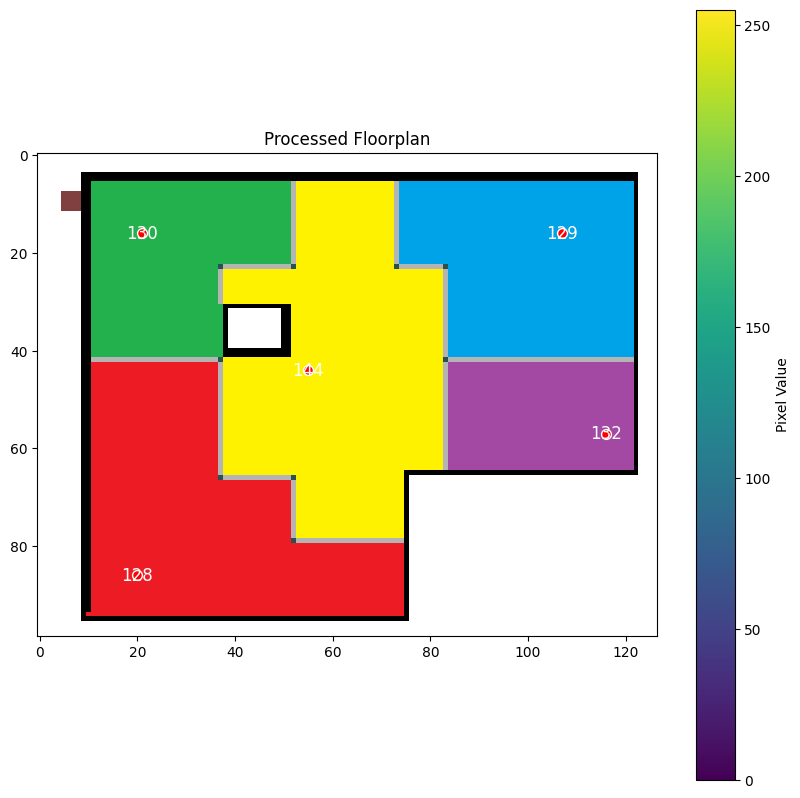

(97, 124)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  

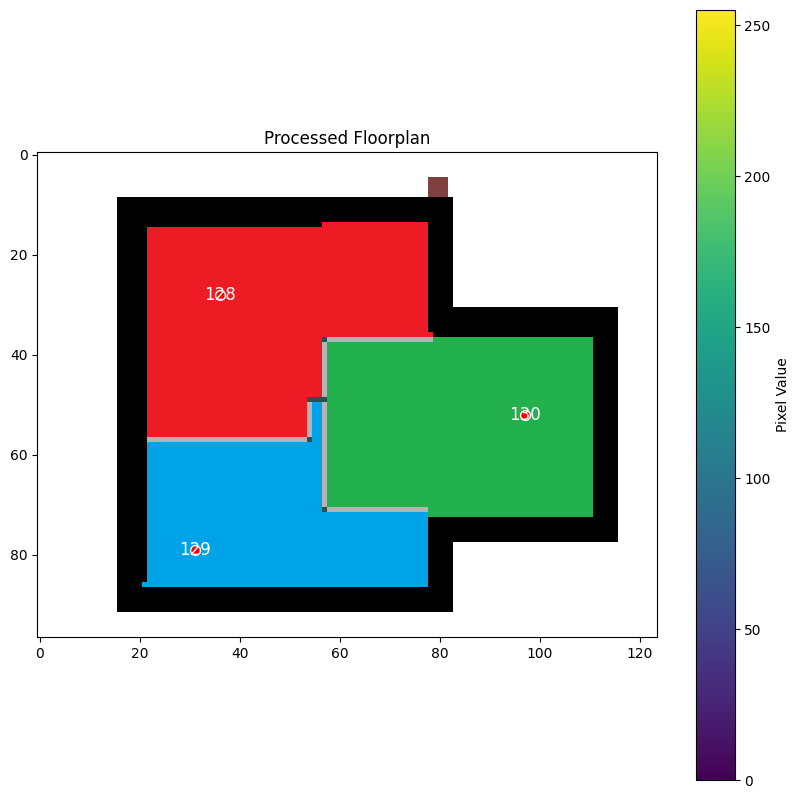

(121, 136)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

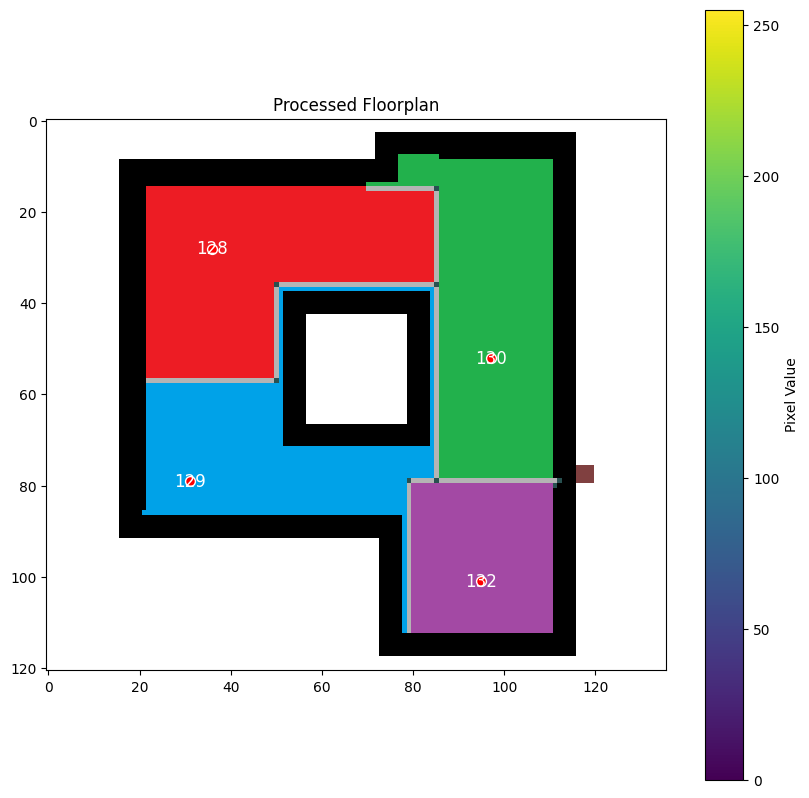

(132, 152)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

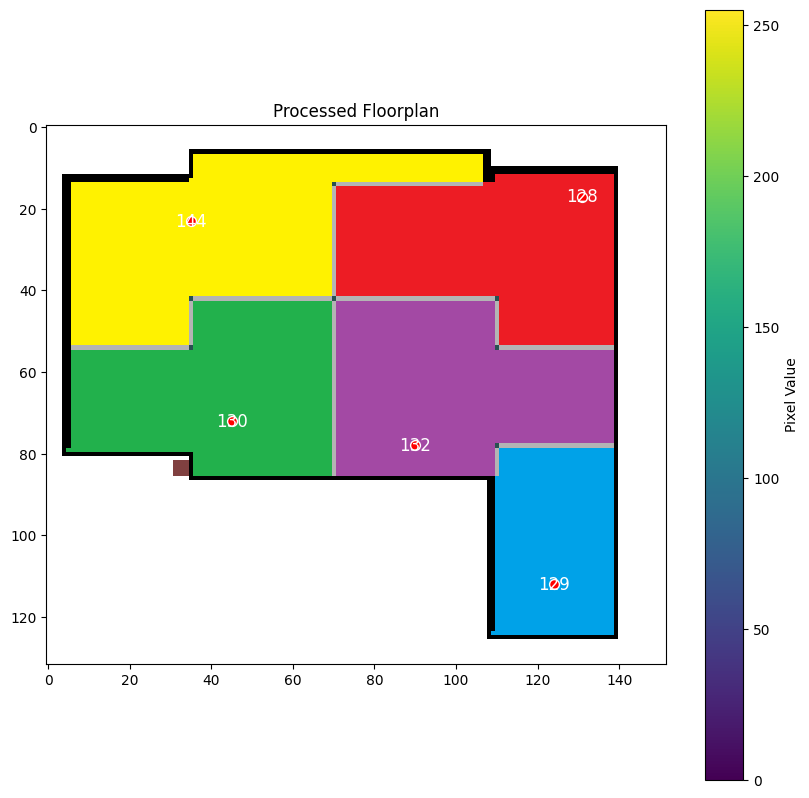

(137, 192)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

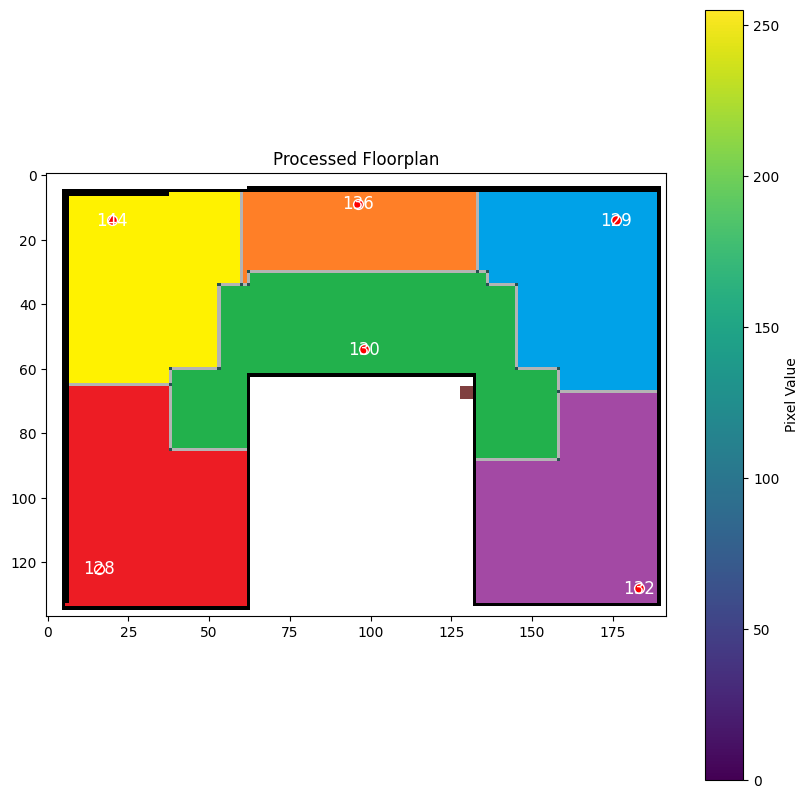

(120, 117)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  

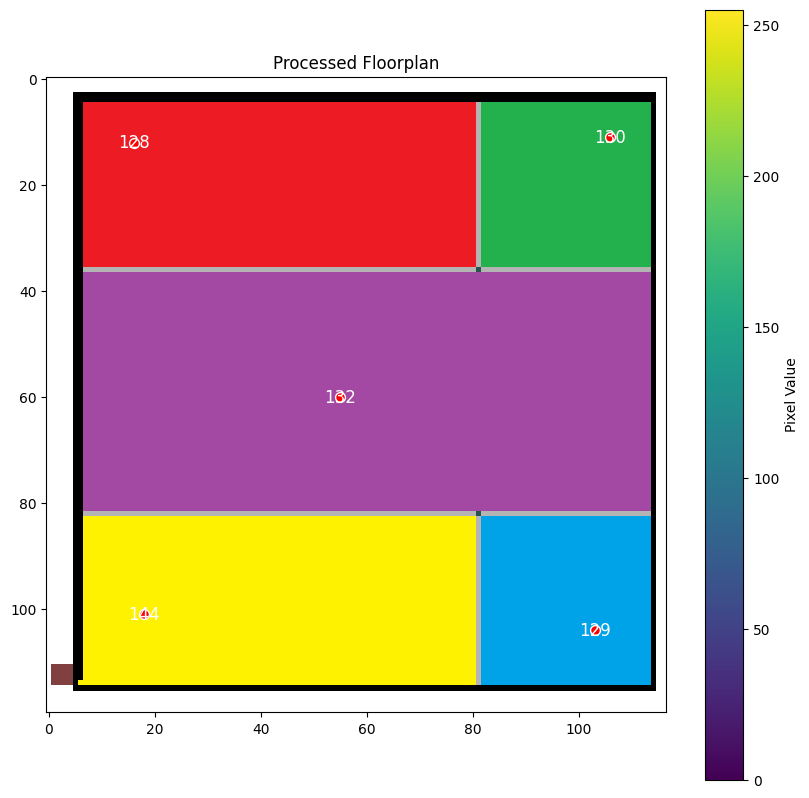

(175, 214)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

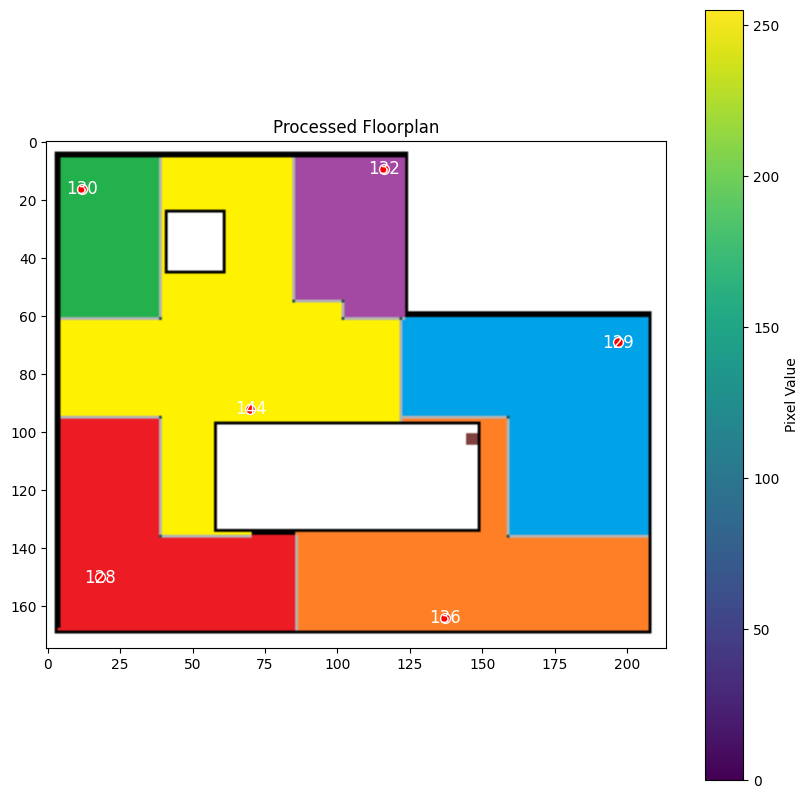

(72, 232)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  

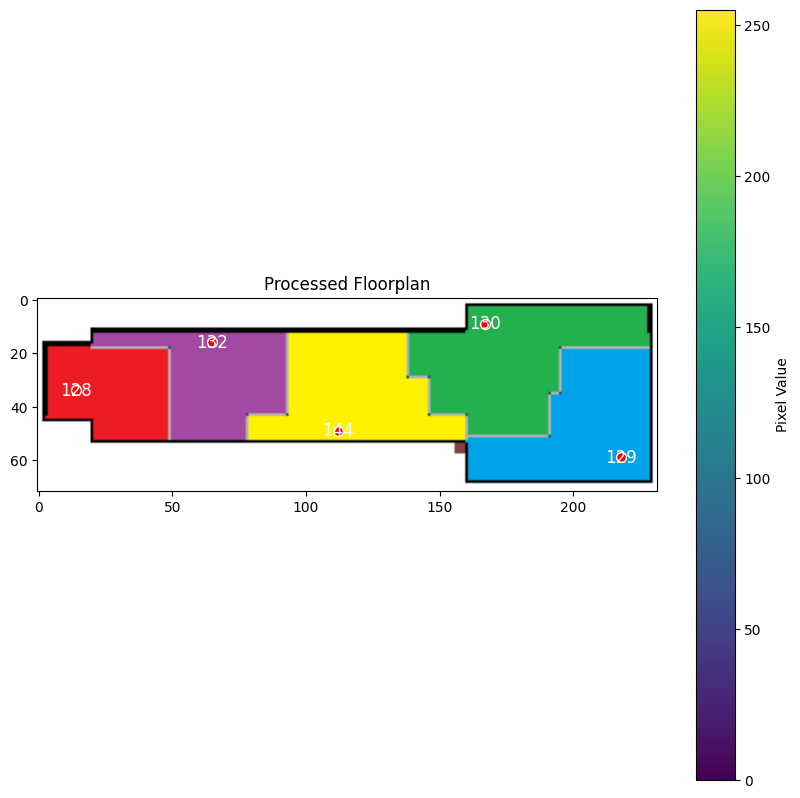

(222, 245)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 

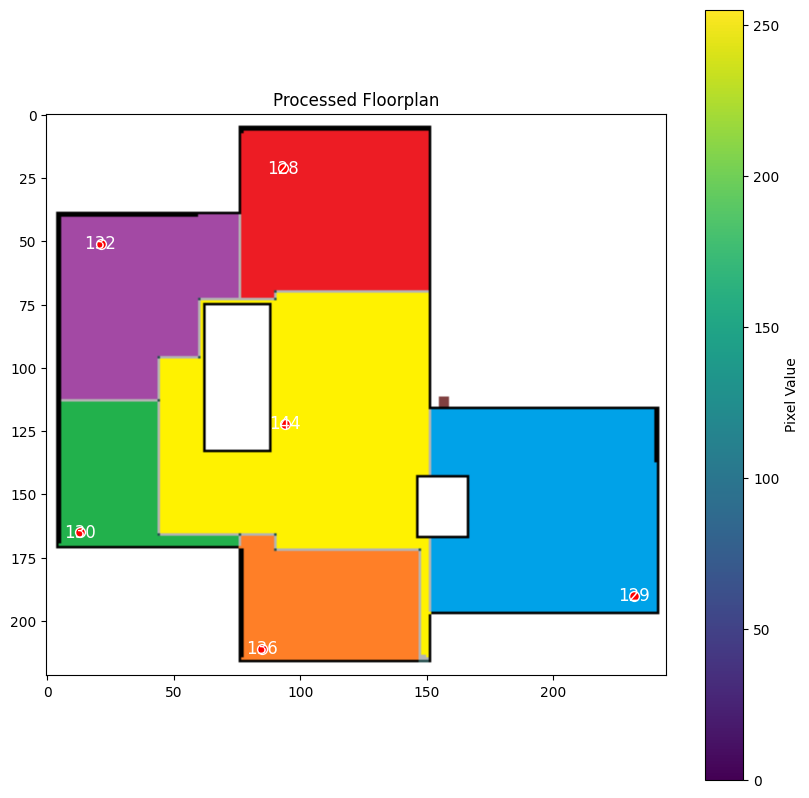

(158, 168)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

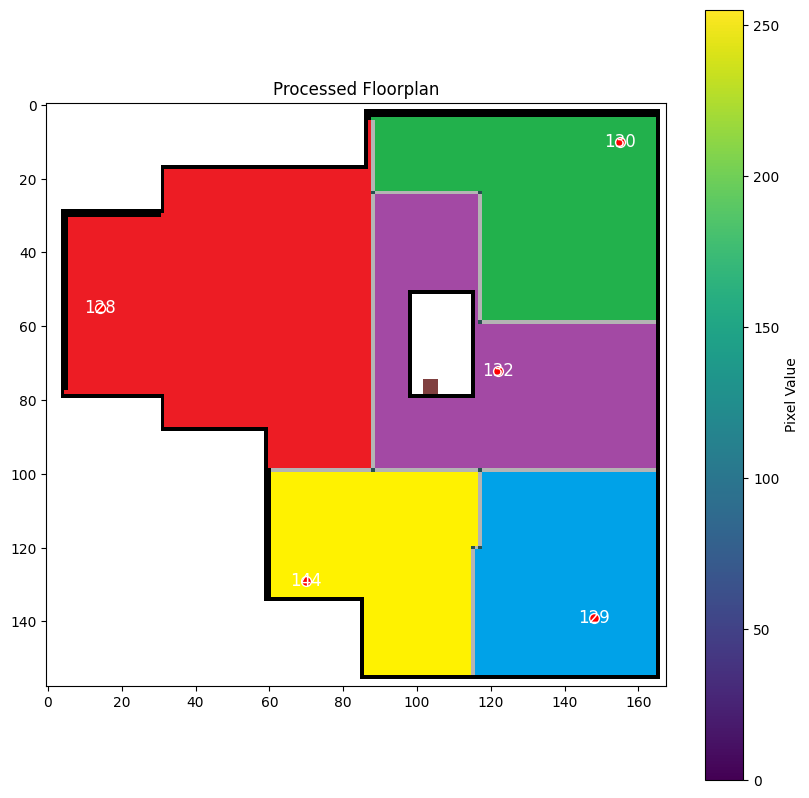

(203, 151)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

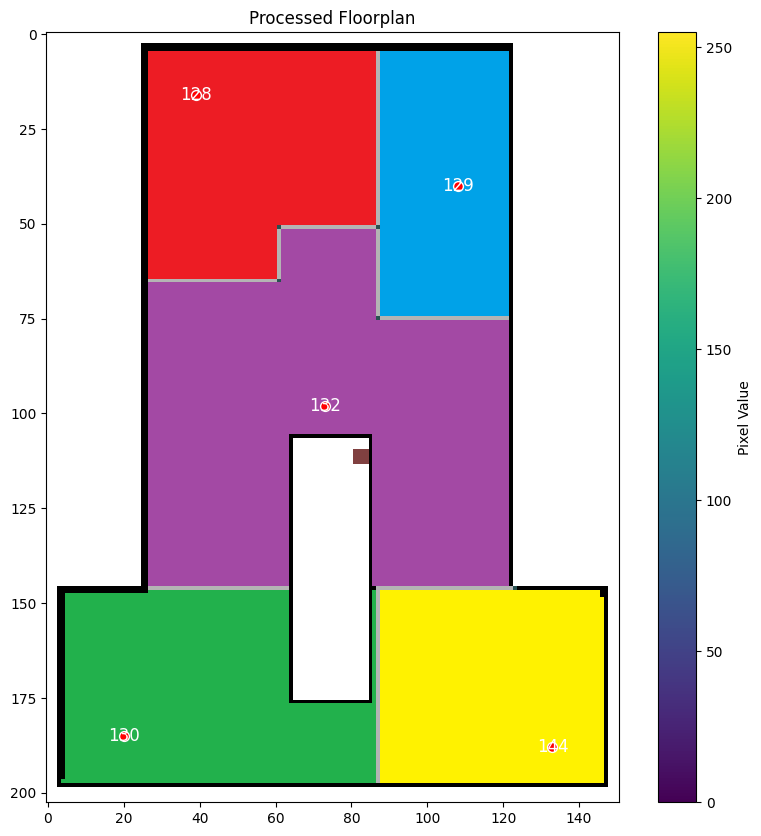

In [ ]:
for floorplan, seed in zip(seeded_floorplans, seeds[1:]):
    print(floorplan.shape)
    print(floorplan)
    result_stair = place_stairwell(floorplan, 4, 4)
    print("4-Connected Result:")
    plot_floorplan(int_to_color(result_stair), seed)

In [ ]:
import numpy as np
from collections import deque

def get_neighbors(coord, skeleton):
    """Return 8-connected neighbors on the skeleton (only if value==1)."""
    y, x = coord
    neighbors = []
    for dy, dx in [(-1, -1), (-1, 0), (-1, 1),
                   (0, -1),           (0, 1), 
                   (1, -1),  (1, 0),  (0, 1)]:
        ny, nx = y + dy, x + dx
        if 0 <= ny < skeleton.shape[0] and 0 <= nx < skeleton.shape[1]:
            if skeleton[ny, nx]:
                neighbors.append((ny, nx))
    return neighbors

def bfs_on_skeleton(skeleton, start_nodes, target_set):
    """
    Perform a multi-source BFS from start_nodes over skeleton pixels until
    any pixel in target_set is reached. Returns the shortest path (as a list
    of (y,x) coordinates) from one of the start nodes to the target.
    """
    queue = deque()
    visited = set()
    parent = {}  # For path reconstruction
    
    for node in start_nodes:
        queue.append(node)
        visited.add(node)
        parent[node] = None
    
    while queue:
        current = queue.popleft()
        if current in target_set:
            # Reconstruct path from the start to current.
            path = []
            while current is not None:
                path.append(current)
                current = parent[current]
            path.reverse()
            return path
        for nb in get_neighbors(current, skeleton):
            if nb not in visited:
                visited.add(nb)
                parent[nb] = current
                queue.append(nb)
    return None  # No connection found

def find_room_boundaries(grid, room_value, skeleton):
    """
    Returns a list of skeleton pixel coordinates that are adjacent
    (4-connected) to any cell belonging to the room (or stairwell).
    """
    bounds = set()
    room_cells = np.argwhere(grid == room_value)
    for y, x in room_cells:
        for dy, dx in [(-1, -1), (-1, 0), (-1, 1),
                       (0, -1),           (0, 1), 
                       (1, -1),  (1, 0),  (1, 1)]:
            ny, nx = y + dy, x + dx
            if 0 <= ny < grid.shape[0] and 0 <= nx < grid.shape[1]:
                if skeleton[ny, nx]:
                    bounds.add((ny, nx))
    return list(bounds)

def find_optimal_corridor_tree(grid):
    """
    Constructs a minimal corridor tree (corridor pixels marked as 21)
    that connects the stairwell (20) to all rooms (all values except 0,1,18,19,20,21).
    The algorithm uses the skeleton of possible corridor locations and a
    multi-target BFS to add the shortest connection from the growing tree
    to each unconnected room.
    """
    # Build the skeleton (corridors allowed where grid==1, 18, or 19)
    skeleton = np.where((grid == 1) | (grid == 18) | (grid == 19), 1, 0).astype(np.uint8)
    
    # Identify room values (exclude corridors, special values, and stairwell)
    rooms = [val for val in np.unique(grid) if val not in {0, 1, 18, 19, 21} and val != 20]
    
    stair_pos = np.argwhere(grid == 20)
    if len(stair_pos) == 0:
        raise ValueError("No stairwell (20) found in grid")
    
    boundaries = {}
    for room in rooms + [20]:
        boundaries[room] = find_room_boundaries(grid, room, skeleton)
    print(boundaries)
    
    # --- Initialization ---
    # Start with a single seed from the stairwell boundary.
    if not boundaries[20]:
        raise ValueError("Stairwell has no valid boundary on the skeleton")
    
    tree_nodes = set([boundaries[20][0]])  # our initial tree (a single pixel)
    connected_rooms = {20}  # the stairwell is our seed
    unconnected_rooms = set(rooms)  # remaining rooms
    
    # Build mapping for each room: room id -> set of boundary pixels (as candidates)
    target_boundaries = {room: set(boundaries[room]) for room in unconnected_rooms}
    
    # --- Iteratively add the shortest connection from the tree to a new room ---
    while unconnected_rooms:
        # Create a union of all target pixels from unconnected rooms.
        target_union = {}
        for room, nodes in target_boundaries.items():
            for node in nodes:
                target_union[node] = room  # if a pixel belongs to multiple, one mapping is enough.
        
        # Run BFS from the current tree_nodes until we hit any target boundary pixel.
        path = bfs_on_skeleton(skeleton, tree_nodes, set(target_union.keys()))
        if path is None:
            break
            raise ValueError("No path found from the current tree to one of the rooms")
        
        # The reached target pixel tells us which room is connected.
        target_pixel = path[-1]
        room_id = target_union[target_pixel]
        
        # Add the entire path to the tree.
        for p in path:
            tree_nodes.add(p)
        
        # Mark the room as connected.
        connected_rooms.add(room_id)
        unconnected_rooms.remove(room_id)
        del target_boundaries[room_id]
    
    # --- Annotate the corridors in the grid ---
    for y, x in tree_nodes:
        grid[y, x] = 21


    return widen_corridors(grid)

def widen_corridors(grid, val = 21, min_width = 4):
    """ 
    Expands corridor to minimum width
    """
    corridor_mask = (grid==val)
    valid_mask = (grid != 0)

    iterations = (min_width) // 2

    kernel = [(-1, -1), (-1, 0), (-1, 1),
              ( 0, -1),          ( 0, 1),
              ( 1, -1), ( 1, 0), ( 1, 1)]
    
    for _ in range(iterations):
        expansion = np.zeros_like(corridor_mask)
        for dy, dx in kernel:
            shifted = np.roll(corridor_mask, shift = (dy, dx), axis = (0,1 ))
            expansion |= shifted

        expansion &= valid_mask
        expansion &= ~corridor_mask
        corridor_mask |= expansion

    grid[corridor_mask] = val
    return grid


(99, 127)
{128: [(43, 37), (66, 39), (84, 75), (95, 20), (95, 75), (45, 10), (56, 10), (76, 52), (42, 11), (60, 10), (79, 60), (45, 37), (56, 37), (95, 50), (95, 59), (60, 37), (67, 52), (78, 52), (42, 32), (95, 13), (95, 68), (62, 10), (73, 10), (95, 22), (62, 37), (79, 53), (75, 10), (85, 75), (95, 43), (95, 52), (79, 10), (42, 25), (90, 10), (79, 74), (95, 61), (95, 70), (42, 34), (95, 15), (87, 75), (66, 46), (92, 10), (91, 75), (68, 52), (95, 36), (76, 10), (52, 10), (95, 45), (72, 52), (42, 18), (95, 54), (79, 67), (95, 63), (42, 27), (52, 37), (95, 72), (42, 36), (70, 52), (54, 10), (74, 52), (66, 48), (93, 10), (58, 10), (69, 10), (80, 10), (94, 9), (54, 37), (95, 29), (95, 38), (95, 47), (58, 37), (42, 20), (95, 56), (79, 69), (95, 65), (42, 29), (71, 10), (81, 75), (82, 10), (86, 10), (66, 41), (66, 50), (95, 31), (83, 75), (94, 75), (95, 40), (95, 49), (42, 13), (44, 10), (79, 62), (88, 10), (95, 58), (42, 22), (79, 71), (95, 67), (42, 31), (72, 10), (48, 10), (44, 37), (66,

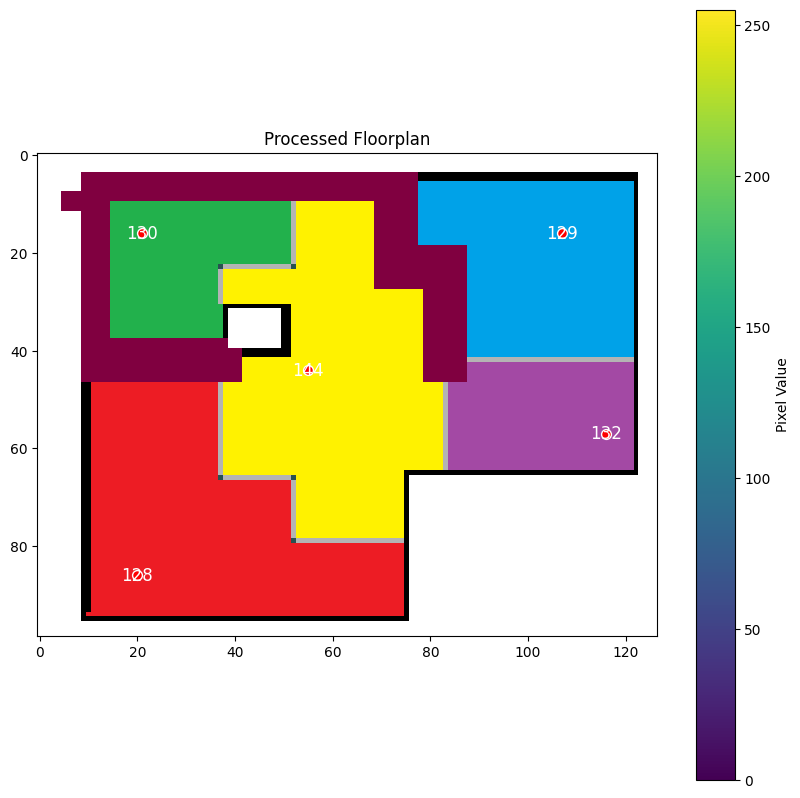

(97, 124)
{128: [(15, 21), (26, 21), (42, 57), (37, 70), (57, 48), (14, 22), (17, 21), (28, 21), (46, 57), (14, 31), (14, 40), (32, 21), (13, 72), (43, 21), (14, 49), (15, 78), (26, 78), (50, 54), (37, 63), (57, 41), (34, 21), (37, 72), (45, 21), (56, 21), (57, 50), (17, 78), (14, 24), (28, 78), (49, 55), (14, 33), (13, 65), (14, 42), (32, 78), (13, 74), (14, 51), (18, 21), (47, 57), (57, 34), (37, 65), (34, 78), (57, 43), (22, 21), (37, 74), (57, 52), (14, 26), (13, 58), (38, 57), (14, 35), (49, 57), (57, 27), (13, 67), (14, 44), (13, 76), (24, 21), (35, 21), (55, 54), (18, 78), (37, 58), (39, 21), (57, 36), (37, 67), (22, 78), (57, 45), (37, 76), (37, 21), (57, 54), (14, 28), (13, 60), (14, 37), (41, 21), (52, 21), (13, 69), (13, 78), (24, 78), (35, 78), (57, 29), (37, 60), (54, 21), (57, 38), (37, 69), (57, 47), (37, 78), (14, 21), (43, 57), (14, 30), (13, 62), (13, 71), (16, 21), (45, 57), (57, 22), (57, 31), (37, 62), (20, 21), (31, 21), (37, 71), (51, 54), (57, 40), (57, 49), (14

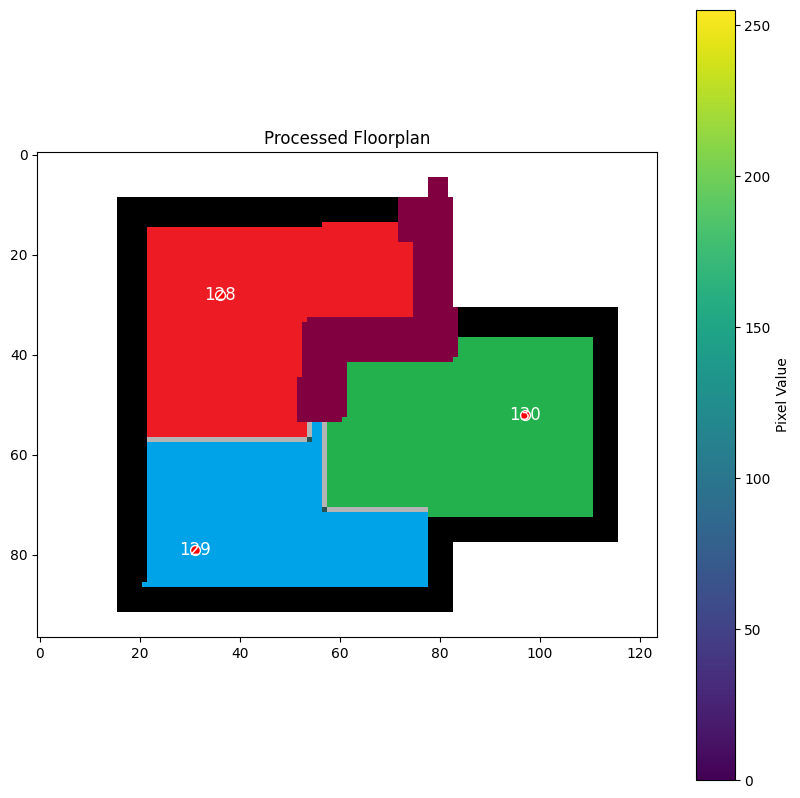

(121, 136)
{128: [(15, 21), (26, 21), (15, 85), (26, 85), (36, 53), (36, 62), (36, 71), (36, 80), (57, 48), (14, 22), (17, 21), (28, 21), (17, 85), (14, 31), (28, 85), (40, 50), (14, 40), (32, 21), (43, 21), (14, 49), (32, 85), (55, 50), (15, 78), (36, 55), (42, 50), (36, 64), (36, 73), (34, 21), (45, 21), (56, 21), (34, 85), (36, 82), (46, 50), (57, 41), (57, 50), (14, 24), (14, 33), (14, 42), (15, 71), (14, 51), (15, 80), (18, 21), (36, 57), (18, 85), (36, 66), (57, 34), (36, 75), (22, 21), (57, 43), (22, 85), (36, 84), (14, 26), (14, 35), (14, 44), (15, 73), (24, 21), (35, 21), (24, 85), (15, 82), (35, 85), (36, 50), (47, 50), (36, 59), (39, 21), (36, 68), (51, 50), (14, 65), (57, 36), (36, 77), (57, 45), (37, 21), (38, 50), (14, 28), (49, 50), (14, 37), (41, 21), (52, 21), (53, 50), (15, 75), (36, 52), (36, 61), (57, 29), (14, 58), (36, 70), (54, 21), (14, 67), (57, 38), (57, 47), (14, 21), (14, 30), (15, 77), (16, 21), (36, 54), (57, 22), (16, 85), (36, 63), (57, 31), (14, 60), (2

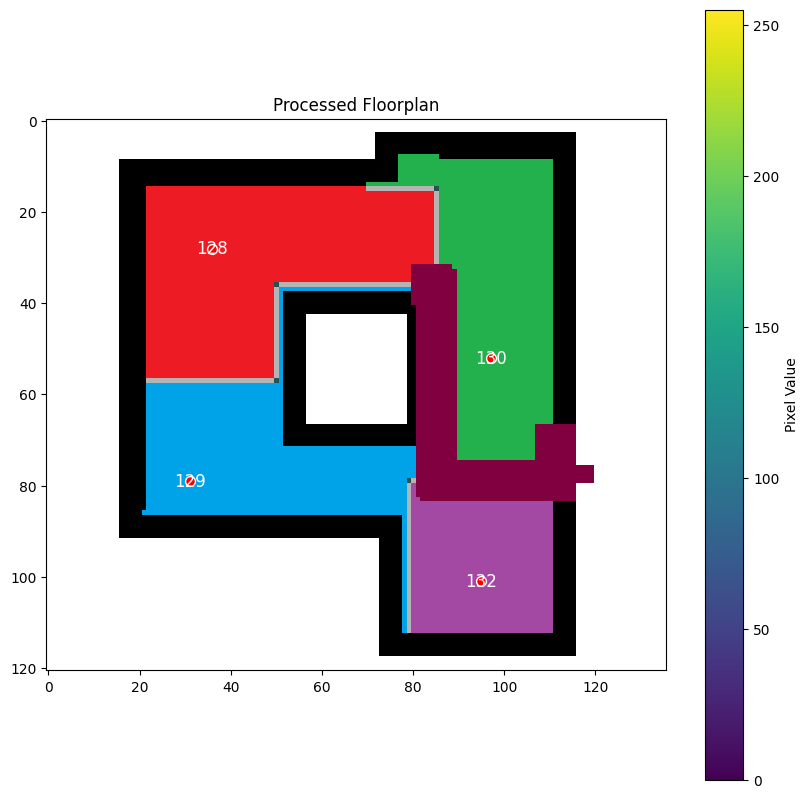

(132, 152)
{128: [(29, 139), (40, 139), (42, 103), (43, 110), (37, 70), (11, 115), (42, 75), (11, 124), (14, 86), (42, 139), (11, 133), (14, 95), (54, 113), (14, 104), (46, 139), (42, 96), (42, 105), (13, 108), (27, 70), (11, 117), (14, 79), (11, 126), (49, 110), (14, 88), (19, 139), (30, 139), (11, 135), (14, 97), (54, 115), (12, 109), (14, 106), (29, 70), (16, 70), (40, 70), (42, 89), (42, 98), (21, 139), (42, 107), (54, 136), (11, 110), (14, 72), (36, 139), (47, 139), (11, 119), (14, 81), (11, 128), (14, 90), (51, 139), (11, 137), (33, 70), (14, 99), (42, 82), (42, 91), (38, 139), (25, 139), (49, 139), (42, 100), (52, 110), (54, 129), (42, 109), (53, 139), (54, 138), (11, 112), (14, 74), (19, 70), (11, 121), (30, 70), (14, 83), (11, 130), (14, 92), (11, 139), (14, 101), (42, 84), (42, 93), (15, 139), (26, 139), (45, 110), (54, 122), (42, 102), (54, 131), (36, 70), (23, 70), (11, 114), (14, 76), (11, 123), (17, 139), (14, 85), (28, 139), (11, 132), (14, 94), (42, 77), (32, 139), (43,

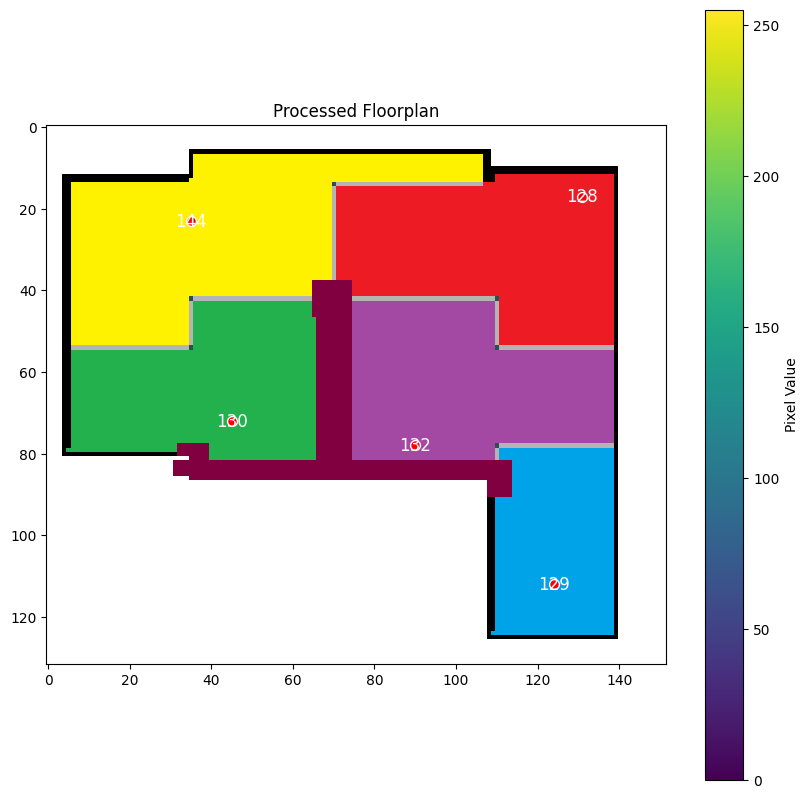

(137, 192)
{128: [(126, 62), (91, 62), (102, 62), (134, 12), (105, 6), (71, 38), (82, 38), (85, 55), (116, 6), (127, 6), (134, 21), (134, 30), (65, 6), (76, 6), (131, 6), (132, 5), (65, 15), (134, 39), (128, 62), (104, 62), (115, 62), (67, 6), (78, 6), (89, 6), (65, 36), (134, 5), (134, 60), (85, 48), (134, 14), (93, 6), (85, 57), (134, 23), (134, 32), (65, 8), (121, 62), (132, 62), (84, 6), (95, 6), (106, 6), (65, 29), (110, 6), (65, 38), (76, 38), (134, 7), (134, 62), (85, 50), (134, 16), (118, 62), (94, 62), (85, 59), (108, 6), (134, 25), (134, 34), (122, 62), (68, 6), (112, 6), (67, 38), (78, 38), (123, 6), (72, 6), (134, 55), (65, 31), (124, 62), (85, 43), (70, 6), (100, 62), (111, 62), (125, 6), (85, 52), (134, 9), (134, 18), (85, 61), (74, 6), (85, 6), (129, 6), (84, 38), (134, 27), (113, 62), (134, 48), (65, 24), (87, 6), (117, 62), (134, 57), (65, 33), (85, 45), (134, 11), (91, 6), (68, 38), (85, 54), (102, 6), (134, 20), (130, 62), (72, 38), (103, 62), (90, 62), (101, 62), (1

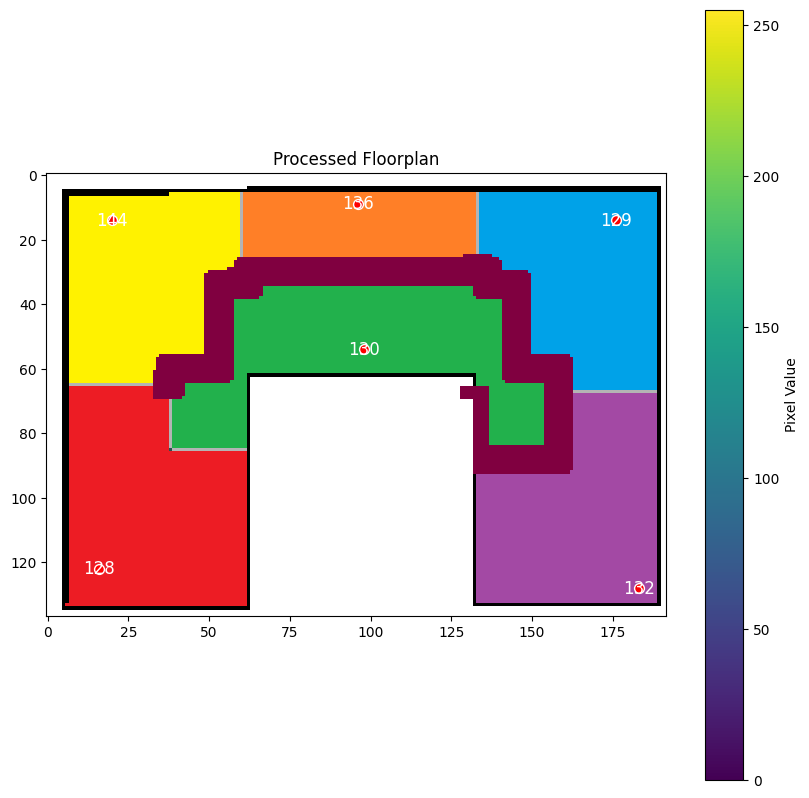

(120, 117)
{128: [(4, 55), (36, 53), (4, 64), (7, 81), (4, 9), (18, 81), (36, 7), (4, 73), (36, 62), (36, 71), (36, 16), (22, 81), (36, 80), (10, 6), (36, 25), (4, 30), (9, 81), (4, 39), (4, 48), (13, 81), (24, 81), (35, 81), (36, 46), (4, 57), (36, 55), (4, 66), (36, 64), (36, 9), (27, 6), (36, 73), (36, 18), (4, 23), (4, 32), (4, 41), (16, 6), (29, 6), (4, 50), (36, 48), (4, 59), (36, 57), (36, 66), (36, 11), (36, 75), (36, 20), (14, 81), (4, 25), (33, 6), (4, 34), (4, 43), (6, 6), (36, 41), (4, 52), (36, 50), (16, 81), (4, 61), (36, 59), (36, 68), (36, 13), (20, 81), (31, 81), (36, 77), (19, 6), (30, 6), (4, 18), (4, 27), (4, 36), (36, 34), (4, 45), (33, 81), (36, 43), (4, 54), (36, 52), (36, 61), (36, 6), (12, 6), (23, 6), (36, 70), (4, 11), (4, 75), (4, 20), (4, 29), (36, 27), (4, 38), (25, 6), (36, 36), (4, 47), (10, 81), (36, 45), (36, 54), (36, 63), (4, 68), (4, 13), (12, 81), (23, 81), (4, 77), (4, 22), (4, 31), (27, 81), (36, 29), (15, 6), (4, 40), (26, 6), (36, 38), (36, 47)

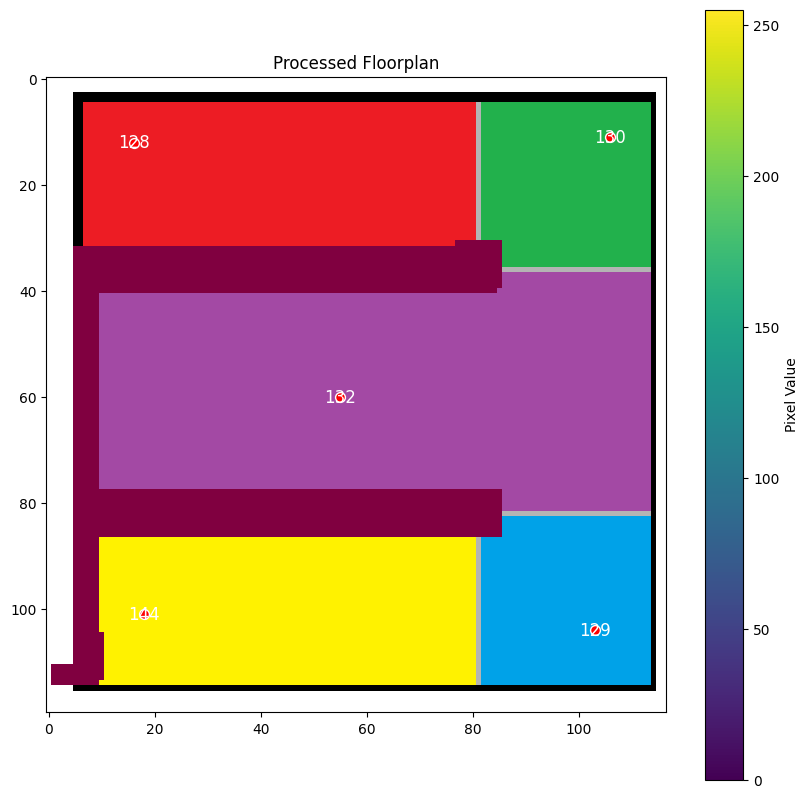

(175, 214)
{128: [(169, 79), (121, 39), (132, 39), (133, 4), (144, 4), (95, 4), (106, 4), (146, 86), (95, 13), (95, 22), (135, 76), (136, 41), (163, 4), (136, 50), (169, 47), (169, 56), (169, 65), (169, 74), (169, 83), (113, 39), (125, 4), (95, 8), (169, 42), (157, 86), (168, 86), (169, 51), (169, 60), (169, 69), (169, 78), (124, 39), (135, 39), (136, 4), (147, 4), (169, 28), (169, 37), (169, 46), (97, 39), (98, 4), (169, 55), (138, 86), (149, 86), (160, 86), (169, 64), (155, 4), (166, 4), (105, 39), (116, 39), (117, 4), (127, 39), (128, 4), (139, 4), (169, 23), (169, 32), (169, 41), (169, 50), (169, 59), (101, 4), (158, 4), (169, 9), (108, 39), (109, 4), (120, 4), (169, 18), (169, 27), (169, 36), (169, 45), (141, 86), (152, 86), (169, 4), (169, 13), (169, 22), (169, 31), (119, 39), (131, 4), (144, 86), (169, 8), (150, 4), (161, 4), (169, 17), (169, 26), (100, 39), (111, 39), (112, 4), (123, 4), (163, 86), (95, 36), (169, 3), (169, 12), (130, 39), (142, 4), (153, 4), (104, 4), (115, 4)

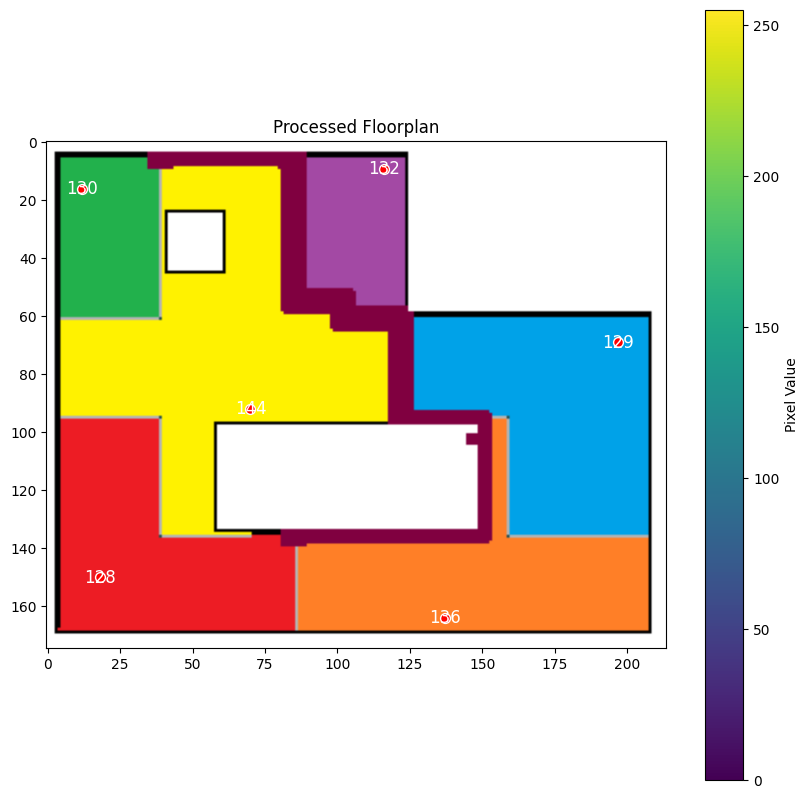

(72, 232)
{128: [(41, 49), (52, 49), (18, 26), (45, 10), (53, 23), (17, 3), (18, 35), (28, 3), (45, 19), (53, 32), (17, 12), (18, 44), (32, 3), (43, 3), (46, 20), (34, 3), (45, 3), (18, 28), (45, 12), (53, 25), (17, 5), (18, 37), (53, 34), (17, 14), (50, 20), (20, 49), (31, 49), (18, 3), (18, 21), (22, 3), (45, 5), (18, 30), (33, 49), (44, 49), (45, 14), (53, 27), (17, 7), (47, 20), (17, 16), (48, 49), (51, 20), (24, 3), (35, 3), (53, 48), (39, 3), (50, 49), (18, 23), (45, 7), (53, 20), (37, 3), (45, 16), (17, 9), (41, 3), (53, 41), (23, 49), (27, 49), (45, 9), (45, 18), (17, 11), (43, 2), (29, 49), (40, 49), (18, 46), (53, 43), (20, 3), (31, 3), (45, 2), (42, 49), (45, 11), (17, 4), (46, 49), (18, 39), (33, 3), (53, 36), (18, 48), (53, 45), (45, 4), (49, 20), (19, 49), (30, 49), (45, 13), (18, 32), (53, 29), (18, 41), (53, 38), (17, 18), (21, 49), (53, 47), (36, 49), (47, 49), (45, 6), (23, 3), (51, 49), (18, 25), (27, 3), (53, 22), (18, 34), (38, 49), (25, 49), (49, 49), (18, 43), (5

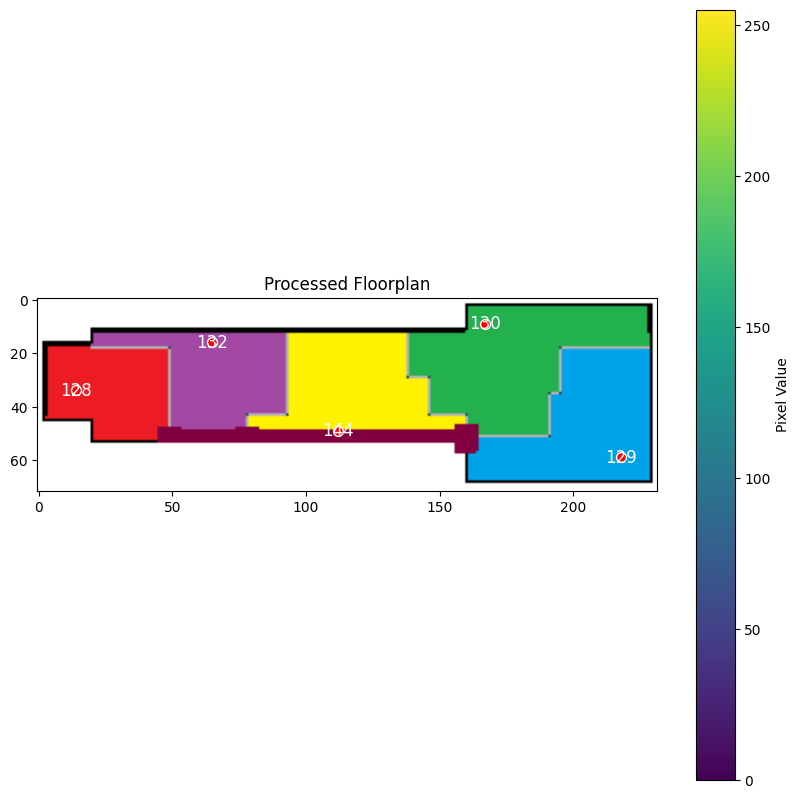

(222, 245)
{128: [(70, 110), (6, 137), (6, 82), (38, 151), (6, 146), (49, 151), (6, 91), (70, 119), (70, 128), (73, 81), (73, 90), (70, 137), (53, 151), (64, 151), (17, 76), (28, 76), (70, 146), (6, 112), (32, 76), (43, 76), (6, 121), (11, 151), (70, 103), (6, 130), (66, 151), (70, 112), (6, 139), (6, 84), (15, 151), (6, 148), (26, 151), (70, 121), (73, 83), (70, 130), (34, 76), (45, 76), (56, 76), (70, 139), (60, 76), (6, 105), (17, 151), (6, 114), (28, 151), (6, 123), (70, 105), (6, 132), (32, 151), (6, 77), (43, 151), (7, 76), (6, 141), (18, 76), (62, 76), (70, 114), (70, 123), (73, 76), (73, 85), (70, 132), (22, 76), (70, 141), (6, 98), (34, 151), (45, 151), (56, 151), (9, 76), (6, 107), (6, 116), (60, 151), (70, 98), (6, 125), (13, 76), (24, 76), (35, 76), (70, 107), (6, 134), (70, 116), (39, 76), (73, 78), (70, 125), (71, 90), (73, 87), (7, 151), (18, 151), (62, 151), (70, 134), (37, 76), (6, 100), (22, 151), (6, 109), (41, 76), (52, 76), (70, 91), (6, 118), (70, 100), (6, 127), 

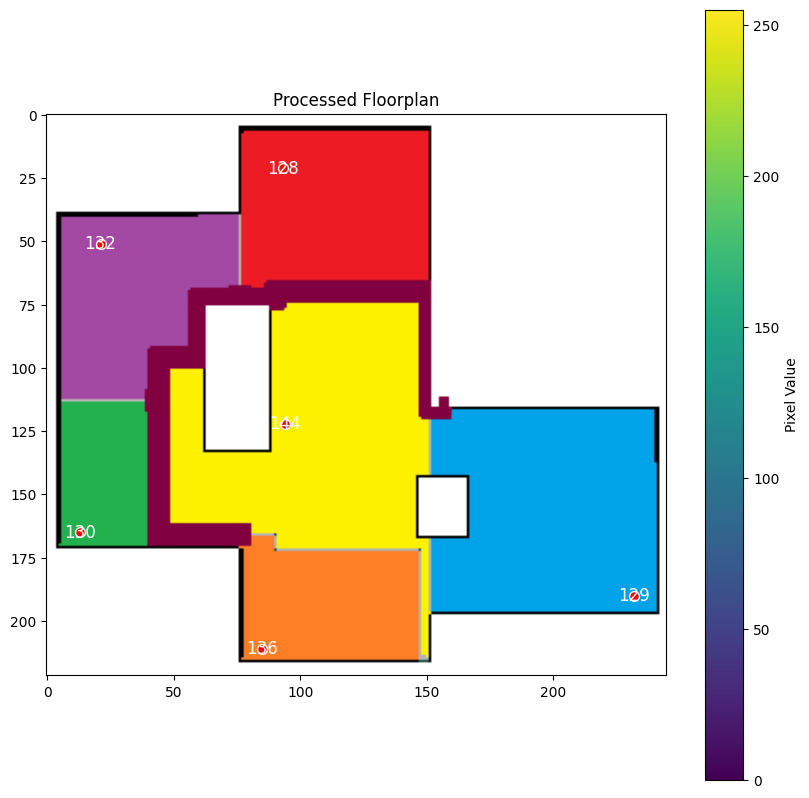

(158, 168)
{128: [(89, 59), (79, 24), (13, 88), (24, 88), (35, 88), (17, 58), (17, 67), (30, 9), (17, 76), (30, 18), (17, 85), (92, 88), (54, 88), (86, 31), (93, 88), (4, 87), (79, 10), (79, 19), (99, 86), (17, 44), (79, 28), (16, 88), (17, 53), (17, 62), (60, 5), (17, 71), (30, 13), (17, 80), (12, 86), (79, 5), (79, 14), (99, 81), (17, 39), (79, 23), (65, 88), (76, 88), (17, 48), (17, 57), (17, 66), (29, 31), (17, 75), (41, 5), (52, 5), (27, 88), (84, 88), (95, 88), (4, 86), (99, 67), (79, 9), (99, 76), (71, 5), (17, 34), (79, 18), (99, 85), (17, 43), (79, 27), (17, 52), (46, 88), (57, 88), (68, 88), (17, 61), (21, 31), (33, 5), (44, 5), (8, 88), (19, 88), (30, 88), (87, 88), (99, 62), (79, 4), (99, 71), (79, 13), (99, 80), (17, 38), (63, 5), (17, 47), (17, 56), (92, 59), (15, 86), (38, 88), (49, 88), (29, 30), (81, 31), (11, 88), (55, 5), (88, 48), (88, 57), (99, 66), (79, 8), (99, 75), (17, 33), (99, 84), (17, 42), (7, 86), (74, 5), (60, 88), (24, 31), (88, 34), (36, 5), (47, 5), (8

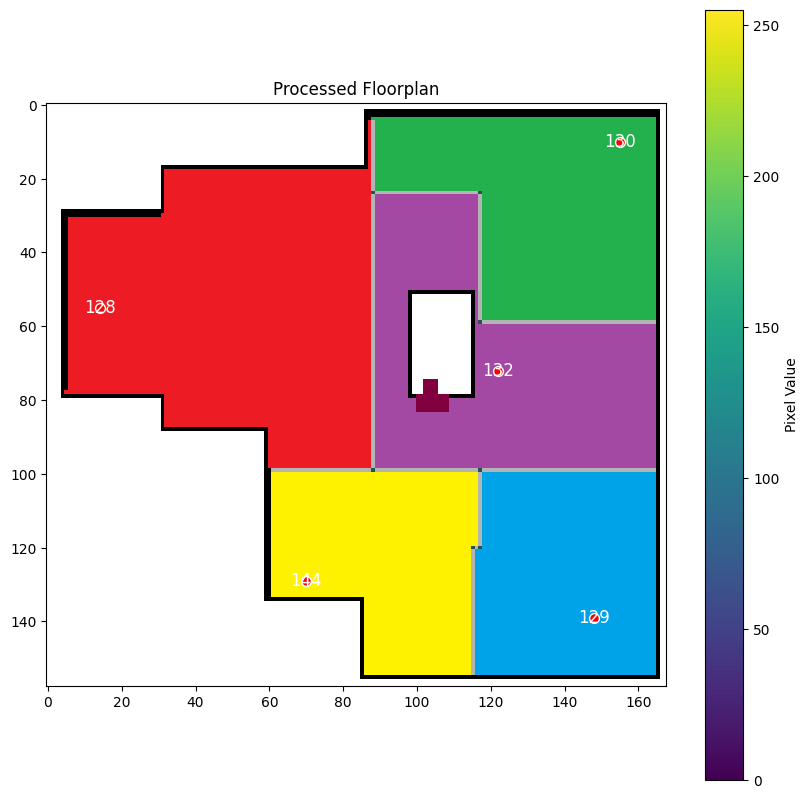

(203, 151)
{128: [(4, 55), (38, 87), (49, 87), (4, 64), (7, 26), (18, 26), (61, 61), (4, 73), (62, 26), (65, 43), (65, 52), (22, 26), (51, 62), (65, 61), (51, 71), (4, 30), (51, 80), (9, 26), (63, 61), (4, 39), (11, 87), (4, 48), (13, 26), (24, 26), (4, 57), (35, 26), (15, 87), (26, 87), (65, 36), (4, 66), (39, 26), (65, 45), (65, 54), (51, 64), (37, 26), (51, 73), (17, 87), (4, 87), (28, 87), (4, 32), (51, 82), (41, 26), (4, 41), (52, 26), (32, 87), (43, 87), (4, 50), (55, 61), (4, 59), (65, 29), (65, 38), (65, 47), (54, 26), (65, 56), (34, 87), (45, 87), (51, 66), (14, 26), (57, 61), (51, 75), (58, 26), (5, 87), (4, 34), (51, 84), (4, 43), (4, 52), (65, 31), (4, 61), (16, 26), (59, 61), (65, 40), (7, 87), (18, 87), (65, 49), (20, 26), (31, 26), (65, 58), (22, 87), (51, 87), (51, 68), (4, 82), (4, 27), (51, 77), (4, 36), (51, 86), (4, 45), (33, 26), (44, 26), (4, 54), (13, 87), (24, 87), (35, 87), (65, 33), (48, 26), (65, 42), (39, 87), (65, 51), (51, 61), (65, 60), (4, 75), (51, 70),

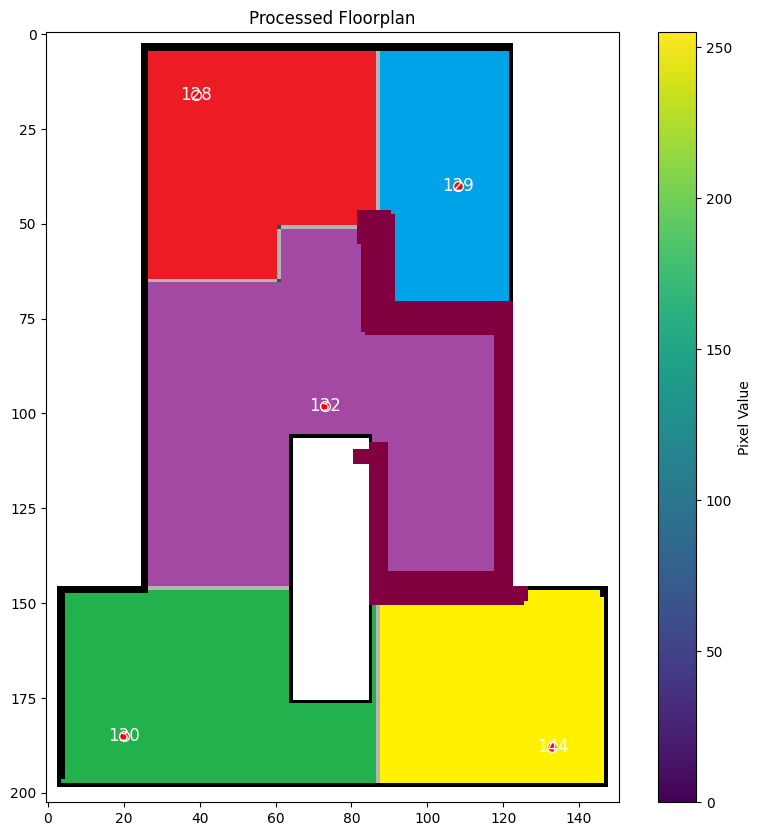

In [ ]:
for floorplan, seed in zip(seeded_floorplans, seeds[1:]):
    print(floorplan.shape)
    
    result_stair = find_optimal_corridor_tree(floorplan)
    result_wide = widen_corridors(result_stair)
    print("4-Connected Result:")
    plot_floorplan(int_to_color(result_stair), seed)
#skeleton = np.where((grid == 0 | grid == 18 | grid == 19), 1, 0).astype(np.uint8)